#NYC subway ridership


In [1]:
import pandas as pd
import datetime

turnstile_weather = pd.read_csv('turnstile_weather_v2.csv')

# Add day of the week to turnstile_weather dataset
#turnstile_weather['weekday'] = [datetime.datetime.strptime(date, '%Y-%m-%d').weekday() for date in turnstile_weather['DATEn']]

#turnstile_weather.describe() # count=131951 ENTRIESn_hourly mean=1095.35 std=2337.02

#turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 0].describe()
#count=87847 mean=1090.28 stdev=2320

#turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 1].describe()
#count=44104 mean=1105.45 stdev=2370.53

#turnstile_weather.columns.values




##Section 1. Statistical Test

### 1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?
A Mann-Whitney U-test is used with an alpha-level of 0.05 (p-critical is 0.05). The independant variable is rainy or non-rainy day, the dependant variable is the number of entries per hour. For now, we cannot be sure in which direction rain affects the number of entries, so our Null-Hypothesis is that we have in average the same number of entries on rainy and non-rainy days, while the alternative hypothesis is that there is a signficant difference:   
$$H_0: \mu_{rain}- \mu_{nonrain}=0$$
$$H_A: \mu_{rain} - \mu_{nonrain} \neq 0$$   

However, as we use the Mann-Whitney U-test we have to formulate it differently. This test cannot test hypthesises on population means.  
$$H_0: P(x_{rain} > x_{norain}) = 0.5$$ 
$$H_A: P(x_{rain} > x_{norain}) \neq 0.5$$  
where x_rain is a random sample drawn from X_rain (which is the hourly entries on rainy days) and x_norain is a random sample drawn from X_norain (which is the hourly entries on non-rainy days). The Null-Hypothesis indicates that you have a 50% chance to gain a higher value for both distributions, e.g. the 2 distributions of the 2 populations (X_rain, X_norain) are equal. The alternative hypothesis states that it is more likely to get higher value for one of the distributions, but as we first do a 2-tailed test we do not say for which one (X_rain or X_norain).  
We use an alpha level of 0.05.


###1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.
The 2 samples that we want to compare (entries on rainy days vs. entries on non-rainy days) are positively skewed (see visualization 3.1). So we cannot use e.g. Welch's t-test as this assumes that the data to be normally distributed. The Mann-Whitney-U Test, however, is a non-parametric test which makes no assumption on the distribution of the underlying data. 
Furthermore our 2 sample are independant and sample sizes are pretty large(about 40000 and about 80000). So it is definitely big enough to get meaningful results from a non-parametric test. 

###1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.



In [2]:
import scipy
import scipy.stats
import numpy as np
from __future__ import division
rain = turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 1]
no_rain = turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 0]
U,p = scipy.stats.mannwhitneyu(no_rain, rain)
print (U,p)
with_rain_mean = np.mean(rain)
without_rain_mean = np.mean(no_rain)
with_rain_median = np.median(rain)
without_rain_median = np.median(no_rain)


result = {'p-Value (1-tailed)': p, 'p-Value (2-tailed)': 2*p, 'mean entries rain': with_rain_mean, 'mean entries no rain': without_rain_mean, 'median entries rain': with_rain_median, 'median entries no rain': without_rain_median}
pd.DataFrame(result,index=[1])

(153635120.5, nan)


,mean entries no rain,mean entries rain,median entries no rain,median entries rain,p-Value (1-tailed),p-Value (2-tailed)
1,1845.539439,2028.196035,893,939,NaN,NaN



###1.4 What is the significance and interpretation of these results?
The p-Value is calculated for a two-tailed test. For an alpha level of 0.05 the p-Value is less than the alpha-level, as a result we can reject the Null-Hypothesis and state that ridership on rainy day is significantly different from ridership on non-rainy days, although the 2 means are not to far apart (just about 15 entries). The 2 medians are even closer together. As the distributions we look at are skewed (see 3.1) the median usually gives a better idea of the data's center.  
We can even adjust our Null-Hypothesis and Alternative Hpothesis to give a direction. As comparing the means and medians implies that we can expect more entries on rainy days:  
$$H_0: P(x_{rain} > x_{norain}) \leq 0.5$$    
$$H_A: P(x_{rain} > x_{norain}) > 0.5$$  
This way we perform a 1-tailed test. Also in this case we can reject the Null Hypothesis (p=0.019 < 0.05). So there are significantly more entries on a rainy day. 


##Section 2. Linear Regression

###2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model: OLS using Statsmodels or Scikit Learn, Gradient descent using Scikit Learn ot something different?
I used OLS using Statsmodels.


###2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?
I used UNIT (a dummy variable) and the features weekday and hour. These seem to achieve the best prediction results for the model. In addition, I added 2 weather-related features: mintempi, maxdewpti and rain, but these only showed little effect.


###2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model.
I experimented with plotting the data and found that there are a few very heavily frequented stations with high entry numbers. Also when you run linear regression without the UNIT you get very bad r squared values, so this seems to be the feature with the highest predictive power.
Then also for different weekdays one gets differing entry numbers (Saturday and Sunday lowest, but also Mondays have less entries). Also when you look at entries per hour there are clear peak hours. 
On the other hand weather-related parameters didn't seem to affect entry numbers that much, but the p-values still indicate that these are significant (see result output below), so I chose rain, mintempi and maxdewpti as these seem to have the biggest effect towards a better r squared value.

###2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

see column coef in the result output below.

###2.5 What is your model’s R2 (coefficients of determination) value?
0.464

###2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?
The r squared value indicates which percentage of the response variabel variation can be explained by the model, so in our case 46,4%. The means more than half the variability canot be explained by the model, which sounds not very good.  

But still the model consists of significant predictors (when you look at the p-values, except for some specific Units) and one can draw conclusions on how changes in the predictors affect the response variable (number of entries).  

However, to predict ridership this linear model is probably not appropriate for this dataset. When we look at the residuals' distribution, especially the probability plot we see that the residuals are not normally distributed. The residuals are not exactly centered around 0 as we have almost straight line which delimits the lower bound of the residuals (probably because we can have only positive or 0 as entry numbers). And for bigger entries the residuals' spread gets wider and wider (see fitted values vs. residuals plot). So for small entry numbers the models predictions are good, but for bigger entry numbers the model gets worse and worse. Also when you plot the actual values vs. the residuals one sees the clear trend again that with bigger entry numbers the residuals increase tremendously. 


                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     242.7
Date:                Fri, 18 Sep 2015   Prob (F-statistic):               0.00
Time:                        09:39:44   Log-Likelihood:            -1.1696e+06
No. Observations:              131951   AIC:                         2.340e+06
Df Residuals:                  131481   BIC:                         2.345e+06
Df Model:                         469                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1771.0469    136.035     13.019      0.0

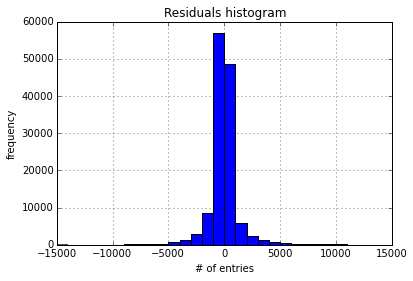

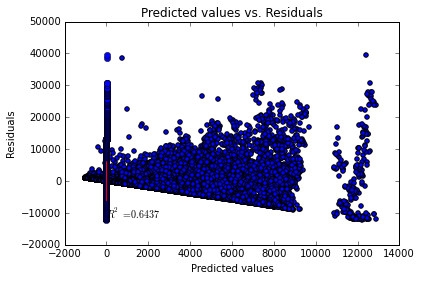

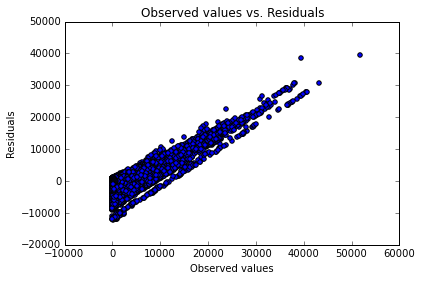

In [124]:
import numpy as np
import pandas
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats


def compute_r_squared(data, predictions):    
    m_y = np.mean(data)
    x_n = np.sum([pow(y-f,2) for (y,f) in zip(data, predictions)])
    x_d = np.sum([pow(y-m_y,2) for y in data])
    r_squared = 1 - x_n / x_d
    return r_squared

################################ MODIFY THIS SECTION #####################################
# Select features. You should modify this section to try different features!             #
# We've selected rain, precipi, Hour, meantempi, and UNIT (as a dummy) to start you off. #
# See this page for more info about dummy variables:                                     #
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html          #
##########################################################################################
#features = turnstile_weather[['rain', 'precipi', 'Hour', 'meantempi']]
features = turnstile_weather[['Hour', 'day_week', 'rain', 'mintempi','maxdewpti']]
dummy_units = pandas.get_dummies(turnstile_weather['UNIT'], prefix='unit')

features = features.join(dummy_units)
#del features['unit_R056']
#del features['unit_R460']
#del features['unit_R054']
del features['unit_R118']


# Values
values = turnstile_weather['ENTRIESn_hourly']

# Perform linear regression
features = sm.add_constant(features)
model = sm.OLS(values, features)
results = model.fit()
params = results.params
print results.summary()
intercept = params[0]
params = params[1:]

del features['const']
predictions = intercept + np.dot(features, params)
#predictions = np.dot(features, params)


%pylab inline
plt.figure()
residuals = (turnstile_weather['ENTRIESn_hourly'] - predictions) 
residuals.hist(bins=30, range=[-15000, 15000])
plt.title('Residuals histogram')
plt.xlabel('# of entries')
plt.ylabel('frequency')


plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.scatter(predictions, residuals)
plt.title('Predicted values vs. Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.figure()
plt.scatter(turnstile_weather['ENTRIESn_hourly'], residuals)
plt.title('Observed values vs. Residuals')
plt.xlabel('Observed values')
plt.ylabel('Residuals')


plt.show()


##Section 3. Visualization

###3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

Populating the interactive namespace from numpy and matplotlib


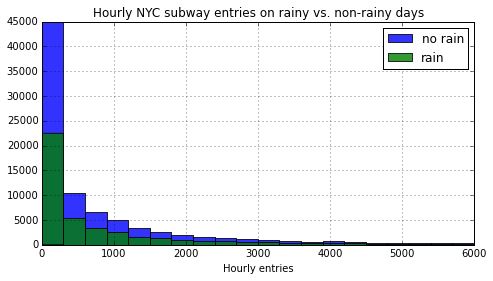

In [107]:
#import numpy as np
#import matplotlib.pyplot as plt

# Causes plots to display within the notebook rather than in a new window
%pylab inline

pylab.figure(figsize=(8,4))
pylab.title(r'Hourly NYC subway entries on rainy vs. non-rainy days')
turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 0].hist(range=[0, 6000], facecolor='blue', alpha=0.8, label = 'no rain', bins=20)
turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 1].hist(range=[0, 6000], facecolor='green', alpha=0.8, label = 'rain', bins=20)

pylab.xlabel('Hourly entries')
pylab.legend()

#no rain: count=87847 mean=1090.28 stdev=2320
#rain: count=44104 mean=1105.45 stdev=2370.53mean = 0
#mean_rain = 1105.45
#mean_norain = 1090.28
#stdev_rain = 2370.53
#stdev_norain = 2320

#x = np.linspace(0,6000,100)
#plt.plot(x,mlab.normpdf(x,mean_rain,stdev_rain),color='blue')
#plt.plot(x,mlab.normpdf(x,mean_norain,stdev_norain),color='green')

# Tweak spacing to prevent clipping of ylabel
pylab.subplots_adjust(left=0.15)
pylab.show()




The histogram of the hourly entries on rainy and non-rainy days shows that the data is positively skewed for both samples (rainy and non-rainy). So we cannot assume a normal distribution of the data. However, this histogram is not useful to compare the ridership on rainy and non-rainy days as we have a lot more data for non-rainy days than for rainy days (only about 40.000 for rainy days, but about 80.000 for non-rainy days) which heavily influences the frequency counts in the histogram. 


###3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like.     

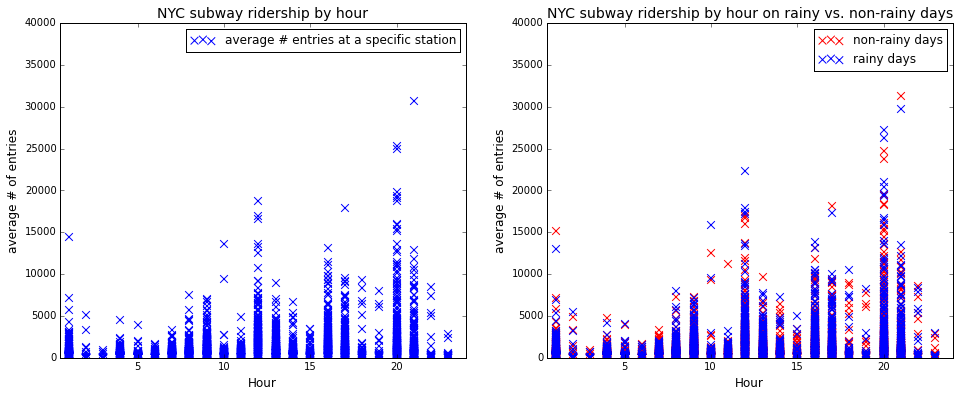

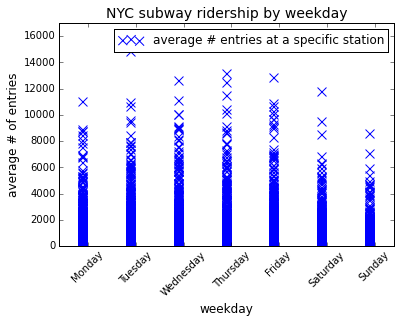

In [118]:
import matplotlib.pyplot as plt
import datetime

# for the color coding we need a number instead of strings for the UNIT.
# order UNITs by mean # of entries
mean_entries = turnstile_weather.groupby('UNIT', as_index=False)['ENTRIESn_hourly'].median()
mean_entries = mean_entries.sort('ENTRIESn_hourly', ascending=True)
mean_entries['station_id'] = range(1,466)
id_map = dict(zip(mean_entries['UNIT'],mean_entries['station_id']))
turnstile_weather['station_id'] = [id_map[a] for a in turnstile_weather['UNIT']]


# Calculate mean # of entries for every Unit/Hour combination
unit_hour = turnstile_weather.groupby(['station_id','Hour'], as_index=False)['ENTRIESn_hourly'].mean()
unit_hour_rain = turnstile_weather[turnstile_weather.rain == 1].groupby(['station_id','Hour'], as_index=False)['ENTRIESn_hourly'].mean()
unit_hour_norain = turnstile_weather[turnstile_weather.rain == 0].groupby(['station_id','Hour'], as_index=False)['ENTRIESn_hourly'].mean()


# Calculate mean # of entries for every Unit/weekday combination
unit_weekday = turnstile_weather.groupby(['station_id','day_week'], as_index=False)['ENTRIESn_hourly'].mean()


#unit_hour['station_id'] = [id_map[a] for a in unit_hour['UNIT']]
#unit_weekday['station_id'] = [id_map[a] for a in unit_weekday['UNIT']]



hot_units = set(mean_entries[mean_entries.ENTRIESn_hourly >= 1300]['station_id'])
cold_units = set(mean_entries[mean_entries.ENTRIESn_hourly < 1300]['station_id'])
turnstile_weather['hot_unit'] = [i in hot_units for i in turnstile_weather['station_id']]

unit_hour_hot = turnstile_weather[turnstile_weather.hot_unit == True].groupby(['station_id','Hour'], as_index=False)['ENTRIESn_hourly'].mean()
unit_hour_cold = turnstile_weather[turnstile_weather.hot_unit == False].groupby(['station_id','Hour'], as_index=False)['ENTRIESn_hourly'].mean()

#
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("NYC subway ridership by hour",fontsize=14)
ax1.set_xlabel("Hour",fontsize=12)
ax1.set_ylabel("average # of entries",fontsize=12)
ax1.set_xlim([0.5, 24])
ax1.set_ylim([0, 40000])
#ax1.scatter(unit_hour['Hour'],unit_hour['ENTRIESn_hourly'],marker='x',s=60, c=unit_hour['station_id'], cmap=get_cmap('Blues'), label='average # entries at a specific station')
ax1.scatter(unit_hour['Hour'],unit_hour['ENTRIESn_hourly'],marker='x',s=60, label='average # entries at a specific station')

ax1.legend()

ax2.set_title("NYC subway ridership by hour on rainy vs. non-rainy days",fontsize=14)
ax2.set_xlabel("Hour",fontsize=12)
ax2.set_ylabel("average # of entries",fontsize=12)
ax2.set_xlim([0.5, 24])
ax2.set_ylim([0, 40000])
ax2.scatter(unit_hour_norain['Hour'],unit_hour_norain['ENTRIESn_hourly'],marker='x',s=60, color='red', label='non-rainy days')
ax2.scatter(unit_hour_rain['Hour'],unit_hour_rain['ENTRIESn_hourly'],marker='x',s=60, color='blue', label='rainy days')
ax2.legend()


#ax21.set_xlim([0.5, 24])
#ax21.set_ylim([0, 40000])
#ax21.scatter(unit_hour_hot['Hour'],unit_hour_hot['ENTRIESn_hourly'],marker='x',s=60, c=unit_hour_hot['station_id'], cmap=get_cmap('Blues'), label='average # entries at a specific station')
#ax21.legend()

#ax22.set_xlim([0.5, 24])
#ax22.set_ylim([0, 40000])
#ax22.scatter(unit_hour_cold['Hour'],unit_hour_cold['ENTRIESn_hourly'],marker='x',s=60, c=unit_hour_cold['station_id'], cmap=get_cmap('Blues'), label='average # entries at a specific station')
#ax22.legend()

#ind = np.arange(len(mean_entries))    # the x locations for the groups
#ax22.bar(ind, mean_entries.ENTRIESn_hourly)

fig1, ax3 = plt.subplots()
ax3.set_title("NYC subway ridership by weekday",fontsize=14)
ax3.set_xlabel("weekday",fontsize=12)
ax3.set_ylabel("average # of entries",fontsize=12)
ax3.set_xlim([-0.5, 6.5])
ax3.set_ylim([0, 17000])

ind = np.arange(7)    
width = 0.1     # the width of the bars: can also be len(x) sequence
xTickMarks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax3.set_xticks(ind+width)
xtickNames = ax3.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

#ax3.scatter(unit_weekday['weekday'], unit_weekday['ENTRIESn_hourly'], marker='x',s=80, c=unit_weekday['station_id'], cmap=plt.cm.Blues, label='average # entries at a specific station')
ax3.scatter(unit_weekday['weekday'], unit_weekday['ENTRIESn_hourly'], marker='x',s=80,label='average # entries at a specific station')

ax3.legend()


#fig1, ax4 = plt.subplots()
#rain = turnstile_weather[turnstile_weather.rain == 1].groupby('Hour')['ENTRIESn_hourly']
#norain = turnstile_weather[turnstile_weather.rain == 0].groupby('Hour')['ENTRIESn_hourly']
#mean_norain = rain.mean()
#median_rain = rain.median()
#median_norain = turnstile_weather[turnstile_weather.rain == 0].groupby('weekday')['ENTRIESn_hourly'].median()
#ax4.scatter(np.arange(24), rain.mean(), color='blue')
#ax4.scatter(np.arange(24), norain.mean(), color='yellow')
#ax4.scatter(np.arange(24), rain.median(), color='green')
#ax4.scatter(np.arange(24), norain.median(), color='orange')



The first scatter plot shows the ridership by hour. The data points represent the average number of entries for a specific UNIT and hour. It can be seen that ridership that in the course of the day ridership varies havily as there are peak hours, e.g. 8pm.  
The second plot is similar to the first one, but the color coding of the data points now indicates rainy vs. non-rainy days. We can see that the hourly enries are not very different on rainy and non-rainy days. 
The third scatter plot shows ridership by weekday. We can see that ridership drops on week-ends and starts and then start building up slowly on mondays.  


##Section 4. Conclusion
Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

###4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

The results of the Mann-Whitney U-test inidicate that there are significantly more people riding the subway when it is raining. So we can state that there is a difference in ridership due to rain and that more people use the subway when it is raining. However, when we want to go a step further and use the results to predict NYC subway ridership, then we find through a linear regression analysis that the effect of rain is significant, but only with little predictive power. Other factors like the UNIT, time of day or weekday seem to be much more important predictors, as far as one can judge from our linear model which is not a good one for the reasons discussed above. 


###4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.
see question above


##Section 5. Reflection
Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

###5.1 Please discuss potential shortcomings of the methods of your analysis, including:
It might be worth to do some additional research on another statistical test for skewed datasets, as this might be more powerful as the test can assume a certain distribution.  
I did not get a linear regression model that is trustworthy. Its results look ok for small entry numbers, but for bigger entry numbers predictions the error gets huge. When we look at the data we find that there are very few stations with these high entry numbers. Maybe the dataset does not contain enough data with regards to these hihgly frequented stations. Or it might be worth to further analyze what is different for these stations, like they might have well-known tourist attractions, city center, .... or other factors that might influence the riding behaviour at these stations. For example, the riding behaviour of commuters might be less affected by rain than that of tourists,... . This might require to add additional information to our dataset from other sources.  
There are probably a lot more statistical methods to get further inside on what is wrong with the linear model (maybe we need a non-linear one) that I'm not aware of.  


###5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

#### References

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test  
scipy reference  
http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-tutorial-and-examples
http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm  
http://matplotlib.org/examples/index.html  
http://matplotlib.org/api/pyplot_api.html  
matplotlib reference  
discussion forum  
